# Train on notebook

In [1]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf

In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [4]:
# Directory where your tumor PNGs are stored
directory = '/root/BiOSGen/data/NKX3'

for filename in os.listdir(directory):
    if filename.endswith('.png') and 'NKX3' not in filename and 'NKX' in filename:
        new_filename = filename.replace('NKX', 'NKX3')
        old_path = os.path.join(directory, filename)
        new_path = os.path.join(directory, new_filename)
        os.rename(old_path, new_path)
        print(f'Renamed: {filename} -> {new_filename}')


In [5]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [6]:
torch.randint(0, len(tree_src.antibodies), (1,)).item()


66

In [7]:
idx_src = torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
)

idx_dst = torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst]))),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  132
idx_dst:  145


In [8]:
pipeline = OSGenPipeline()


/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/flashenv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
trainable_params = sum(p.numel() for p in pipeline.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {trainable_params}")


Number of trainable parameters: 88957769


In [10]:
count = 0
count_float32 = 0
for name, module in pipeline.named_modules():
    for param_name, param in module.named_parameters(recurse=False):
        # print(f"{name}.{param_name}: dtype={param.dtype}")
        if param.dtype == torch.float32:
            count_float32 += 1
        count += 1

print(f"float32 percentage: {count_float32 / count * 100}%")


float32 percentage: 100.0%


In [11]:
# Hyperparameters
verbose = cfg.verbose
num_epochs = cfg.num_epochs
batch_size = cfg.batch_size
lr = cfg.lr
optimizer = optim.AdamW([p for p in pipeline.parameters() if p.requires_grad], 
                        lr=cfg.optimizer.params.lr, weight_decay=cfg.optimizer.params.weight_decay, eps=cfg.optimizer.params.eps)

channels = cfg.channels
height = cfg.height
width = cfg.width
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_content = cfg.lambda_content
lambda_style = cfg.lambda_style

# Training loop
# Put on training mode
pipeline.train()
requires_grad = True

# Early stopping parameters
early_stopping_patience = cfg.early_stopping_patience
epochs_without_improvement = 0
best_loss = float("inf")

# Save losses
losses = []
content_losses = []
style_losses = []

# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    epoch_losses = []
    avg_loss = []
    
    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        decoded = pipeline(src_tensor, dst_tensor, timesteps)

        # Handle gradients issues
        requires_grad = decoded.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute loss
        content_l, style_l, total_loss = pipeline.compute_loss(src_tensor, dst_tensor, decoded, lambda_content, lambda_style)

        # Break if total_loss is NaN
        if torch.isnan(total_loss):
            print(f"NaN loss at epoch {epoch+1}, batch {i+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")

        avg_loss.append(total_loss.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()


    current_loss = np.mean(avg_loss)
    losses.append(current_loss)
    content_losses.append(content_l.item())
    style_losses.append(style_l.item())

    # Early stopping
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        if num_epochs > 100: 
            print(f"Early stopping at epoch {epoch+1}")
            break 
        # print(f"Early stopping at epoch {epoch+1}")
        # break

    if verbose: 
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20, Batch 1/74, Content Loss: 112.0852, Style Loss: 59.2864, Total Loss: 171.3716
Epoch 1/20, Batch 2/74, Content Loss: 136.5627, Style Loss: 268.5634, Total Loss: 405.1260
Epoch 1/20, Batch 3/74, Content Loss: 160.3949, Style Loss: 160.1572, Total Loss: 320.5521
Epoch 1/20, Batch 4/74, Content Loss: 144.9470, Style Loss: 96.7739, Total Loss: 241.7209
Epoch 1/20, Batch 5/74, Content Loss: 125.4919, Style Loss: 137.6398, Total Loss: 263.1317
Epoch 1/20, Batch 6/74, Content Loss: 106.4591, Style Loss: 85.9629, Total Loss: 192.4220
Epoch 1/20, Batch 7/74, Content Loss: 102.3737, Style Loss: 60.1237, Total Loss: 162.4975
Epoch 1/20, Batch 8/74, Content Loss: 112.5372, Style Loss: 37.1173, Total Loss: 149.6545
Epoch 1/20, Batch 9/74, Content Loss: 91.7273, Style Loss: 43.4329, Total Loss: 135.1602
Epoch 1/20, Batch 10/74, Content Loss: 88.5144, Style Loss: 46.7163, Total Loss: 135.2307
Epoch 1/20, Batch 11/74, Content Loss: 105.0428, Style Loss: 35.7371, Total Loss: 140.7799
Epoch 1

  5%|▌         | 1/20 [00:13<04:08, 13.07s/it]

Epoch 1/20, Batch 67/74, Content Loss: 65.1869, Style Loss: 29.3782, Total Loss: 94.5651
Epoch 2/20, Batch 1/74, Content Loss: 88.6789, Style Loss: 28.2376, Total Loss: 116.9165
Epoch 2/20, Batch 2/74, Content Loss: 81.2796, Style Loss: 29.3698, Total Loss: 110.6494
Epoch 2/20, Batch 3/74, Content Loss: 83.2848, Style Loss: 20.4790, Total Loss: 103.7639
Epoch 2/20, Batch 4/74, Content Loss: 73.3521, Style Loss: 33.0748, Total Loss: 106.4268
Epoch 2/20, Batch 5/74, Content Loss: 79.5770, Style Loss: 31.7456, Total Loss: 111.3226
Epoch 2/20, Batch 6/74, Content Loss: 76.9155, Style Loss: 35.4956, Total Loss: 112.4111
Epoch 2/20, Batch 7/74, Content Loss: 87.9708, Style Loss: 29.6332, Total Loss: 117.6040
Epoch 2/20, Batch 8/74, Content Loss: 98.5295, Style Loss: 31.6368, Total Loss: 130.1663
Epoch 2/20, Batch 9/74, Content Loss: 90.5713, Style Loss: 25.6539, Total Loss: 116.2252
Epoch 2/20, Batch 10/74, Content Loss: 76.4237, Style Loss: 22.4599, Total Loss: 98.8836
Epoch 2/20, Batch 11/

 10%|█         | 2/20 [00:22<03:16, 10.91s/it]

Epoch 3/20, Batch 1/74, Content Loss: 67.7930, Style Loss: 11.7747, Total Loss: 79.5677
Epoch 3/20, Batch 2/74, Content Loss: 66.1842, Style Loss: 20.5989, Total Loss: 86.7831
Epoch 3/20, Batch 3/74, Content Loss: 68.3915, Style Loss: 12.1753, Total Loss: 80.5667
Epoch 3/20, Batch 4/74, Content Loss: 59.4525, Style Loss: 17.5483, Total Loss: 77.0008
Epoch 3/20, Batch 5/74, Content Loss: 55.8132, Style Loss: 15.1471, Total Loss: 70.9603
Epoch 3/20, Batch 6/74, Content Loss: 55.1461, Style Loss: 12.3414, Total Loss: 67.4875
Epoch 3/20, Batch 7/74, Content Loss: 74.9472, Style Loss: 10.9057, Total Loss: 85.8529
Epoch 3/20, Batch 8/74, Content Loss: 74.6881, Style Loss: 19.4843, Total Loss: 94.1723
Epoch 3/20, Batch 9/74, Content Loss: 63.4058, Style Loss: 10.8841, Total Loss: 74.2899
Epoch 3/20, Batch 10/74, Content Loss: 55.8433, Style Loss: 10.4548, Total Loss: 66.2981
Epoch 3/20, Batch 11/74, Content Loss: 75.0238, Style Loss: 16.6509, Total Loss: 91.6747
Epoch 3/20, Batch 12/74, Conte

 15%|█▌        | 3/20 [00:32<02:55, 10.33s/it]

Epoch 4/20, Batch 1/74, Content Loss: 59.4402, Style Loss: 7.8696, Total Loss: 67.3098
Epoch 4/20, Batch 2/74, Content Loss: 59.2144, Style Loss: 12.4460, Total Loss: 71.6604
Epoch 4/20, Batch 3/74, Content Loss: 66.7498, Style Loss: 5.7382, Total Loss: 72.4880
Epoch 4/20, Batch 4/74, Content Loss: 53.1957, Style Loss: 16.9733, Total Loss: 70.1689
Epoch 4/20, Batch 5/74, Content Loss: 51.7579, Style Loss: 9.1045, Total Loss: 60.8624
Epoch 4/20, Batch 6/74, Content Loss: 49.7585, Style Loss: 12.6759, Total Loss: 62.4343
Epoch 4/20, Batch 7/74, Content Loss: 65.1853, Style Loss: 6.9493, Total Loss: 72.1345
Epoch 4/20, Batch 8/74, Content Loss: 70.5330, Style Loss: 10.2766, Total Loss: 80.8096
Epoch 4/20, Batch 9/74, Content Loss: 48.0226, Style Loss: 9.3148, Total Loss: 57.3374
Epoch 4/20, Batch 10/74, Content Loss: 49.3001, Style Loss: 4.0672, Total Loss: 53.3672
Epoch 4/20, Batch 11/74, Content Loss: 66.2254, Style Loss: 11.0535, Total Loss: 77.2789
Epoch 4/20, Batch 12/74, Content Los

 20%|██        | 4/20 [00:41<02:39,  9.94s/it]

Epoch 4/20, Batch 67/74, Content Loss: 48.8044, Style Loss: 5.4050, Total Loss: 54.2094
Epoch 5/20, Batch 1/74, Content Loss: 55.5755, Style Loss: 8.6386, Total Loss: 64.2141
Epoch 5/20, Batch 2/74, Content Loss: 56.8329, Style Loss: 11.0341, Total Loss: 67.8670
Epoch 5/20, Batch 3/74, Content Loss: 60.6628, Style Loss: 6.7129, Total Loss: 67.3757
Epoch 5/20, Batch 4/74, Content Loss: 48.2167, Style Loss: 19.2816, Total Loss: 67.4984
Epoch 5/20, Batch 5/74, Content Loss: 49.5914, Style Loss: 11.1790, Total Loss: 60.7704
Epoch 5/20, Batch 6/74, Content Loss: 49.3266, Style Loss: 15.0387, Total Loss: 64.3653
Epoch 5/20, Batch 7/74, Content Loss: 61.1816, Style Loss: 11.9716, Total Loss: 73.1533
Epoch 5/20, Batch 8/74, Content Loss: 65.3363, Style Loss: 10.8915, Total Loss: 76.2278
Epoch 5/20, Batch 9/74, Content Loss: 50.0132, Style Loss: 10.6281, Total Loss: 60.6412
Epoch 5/20, Batch 10/74, Content Loss: 47.0375, Style Loss: 8.1840, Total Loss: 55.2215
Epoch 5/20, Batch 11/74, Content L

 25%|██▌       | 5/20 [00:50<02:26,  9.75s/it]

Epoch 6/20, Batch 1/74, Content Loss: 44.2357, Style Loss: 5.9763, Total Loss: 50.2120
Epoch 6/20, Batch 2/74, Content Loss: 52.2403, Style Loss: 8.4593, Total Loss: 60.6997
Epoch 6/20, Batch 3/74, Content Loss: 55.9959, Style Loss: 7.8055, Total Loss: 63.8015
Epoch 6/20, Batch 4/74, Content Loss: 45.7239, Style Loss: 16.2838, Total Loss: 62.0077
Epoch 6/20, Batch 5/74, Content Loss: 46.8808, Style Loss: 11.3689, Total Loss: 58.2497
Epoch 6/20, Batch 6/74, Content Loss: 45.7244, Style Loss: 13.6536, Total Loss: 59.3781
Epoch 6/20, Batch 7/74, Content Loss: 54.4138, Style Loss: 7.6299, Total Loss: 62.0437
Epoch 6/20, Batch 8/74, Content Loss: 57.4358, Style Loss: 11.0982, Total Loss: 68.5340
Epoch 6/20, Batch 9/74, Content Loss: 42.9943, Style Loss: 8.3961, Total Loss: 51.3904
Epoch 6/20, Batch 10/74, Content Loss: 41.9651, Style Loss: 5.0006, Total Loss: 46.9657
Epoch 6/20, Batch 11/74, Content Loss: 59.0370, Style Loss: 7.7578, Total Loss: 66.7947
Epoch 6/20, Batch 12/74, Content Loss

 30%|███       | 6/20 [01:00<02:14,  9.64s/it]

Epoch 6/20, Batch 67/74, Content Loss: 43.1379, Style Loss: 6.0504, Total Loss: 49.1884
Epoch 7/20, Batch 1/74, Content Loss: 44.0278, Style Loss: 6.3120, Total Loss: 50.3398
Epoch 7/20, Batch 2/74, Content Loss: 48.6861, Style Loss: 5.8311, Total Loss: 54.5173
Epoch 7/20, Batch 3/74, Content Loss: 55.9139, Style Loss: 4.0458, Total Loss: 59.9596
Epoch 7/20, Batch 4/74, Content Loss: 42.0121, Style Loss: 10.4482, Total Loss: 52.4602
Epoch 7/20, Batch 5/74, Content Loss: 44.9733, Style Loss: 7.4283, Total Loss: 52.4016
Epoch 7/20, Batch 6/74, Content Loss: 43.0534, Style Loss: 10.0072, Total Loss: 53.0606
Epoch 7/20, Batch 7/74, Content Loss: 50.0387, Style Loss: 6.3740, Total Loss: 56.4127
Epoch 7/20, Batch 8/74, Content Loss: 52.4861, Style Loss: 7.7739, Total Loss: 60.2600
Epoch 7/20, Batch 9/74, Content Loss: 38.0500, Style Loss: 9.1303, Total Loss: 47.1803
Epoch 7/20, Batch 10/74, Content Loss: 40.5152, Style Loss: 6.1390, Total Loss: 46.6543
Epoch 7/20, Batch 11/74, Content Loss: 

 35%|███▌      | 7/20 [01:09<02:04,  9.56s/it]

Epoch 8/20, Batch 1/74, Content Loss: 42.3092, Style Loss: 6.1152, Total Loss: 48.4244
Epoch 8/20, Batch 2/74, Content Loss: 48.1367, Style Loss: 5.7745, Total Loss: 53.9112
Epoch 8/20, Batch 3/74, Content Loss: 54.1397, Style Loss: 4.3817, Total Loss: 58.5214
Epoch 8/20, Batch 4/74, Content Loss: 44.7289, Style Loss: 9.5118, Total Loss: 54.2407
Epoch 8/20, Batch 5/74, Content Loss: 49.8597, Style Loss: 10.3905, Total Loss: 60.2503
Epoch 8/20, Batch 6/74, Content Loss: 42.7190, Style Loss: 9.0625, Total Loss: 51.7815
Epoch 8/20, Batch 7/74, Content Loss: 49.5686, Style Loss: 6.3745, Total Loss: 55.9431
Epoch 8/20, Batch 8/74, Content Loss: 55.3800, Style Loss: 8.0491, Total Loss: 63.4291
Epoch 8/20, Batch 9/74, Content Loss: 43.5278, Style Loss: 11.5439, Total Loss: 55.0717
Epoch 8/20, Batch 10/74, Content Loss: 39.8753, Style Loss: 7.7745, Total Loss: 47.6498
Epoch 8/20, Batch 11/74, Content Loss: 55.9251, Style Loss: 7.0035, Total Loss: 62.9286
Epoch 8/20, Batch 12/74, Content Loss: 

 40%|████      | 8/20 [01:19<01:54,  9.51s/it]

Epoch 8/20, Batch 67/74, Content Loss: 41.7272, Style Loss: 4.9659, Total Loss: 46.6931
Epoch 9/20, Batch 1/74, Content Loss: 43.2691, Style Loss: 7.5480, Total Loss: 50.8171
Epoch 9/20, Batch 2/74, Content Loss: 49.4430, Style Loss: 6.6193, Total Loss: 56.0623
Epoch 9/20, Batch 3/74, Content Loss: 54.6364, Style Loss: 4.3868, Total Loss: 59.0232
Epoch 9/20, Batch 4/74, Content Loss: 44.7018, Style Loss: 9.2908, Total Loss: 53.9927
Epoch 9/20, Batch 5/74, Content Loss: 45.3056, Style Loss: 7.9528, Total Loss: 53.2584
Epoch 9/20, Batch 6/74, Content Loss: 42.7129, Style Loss: 9.3159, Total Loss: 52.0288
Epoch 9/20, Batch 7/74, Content Loss: 50.0054, Style Loss: 7.3051, Total Loss: 57.3104
Epoch 9/20, Batch 8/74, Content Loss: 51.9361, Style Loss: 7.4184, Total Loss: 59.3545
Epoch 9/20, Batch 9/74, Content Loss: 36.6872, Style Loss: 10.4700, Total Loss: 47.1572
Epoch 9/20, Batch 10/74, Content Loss: 37.8681, Style Loss: 8.6858, Total Loss: 46.5539
Epoch 9/20, Batch 11/74, Content Loss: 5

 45%|████▌     | 9/20 [01:28<01:44,  9.47s/it]

Epoch 10/20, Batch 1/74, Content Loss: 47.1505, Style Loss: 6.6278, Total Loss: 53.7783
Epoch 10/20, Batch 2/74, Content Loss: 51.7400, Style Loss: 7.9083, Total Loss: 59.6482
Epoch 10/20, Batch 3/74, Content Loss: 57.3823, Style Loss: 5.6217, Total Loss: 63.0040
Epoch 10/20, Batch 4/74, Content Loss: 44.5826, Style Loss: 12.8666, Total Loss: 57.4492
Epoch 10/20, Batch 5/74, Content Loss: 45.4952, Style Loss: 8.5576, Total Loss: 54.0528
Epoch 10/20, Batch 6/74, Content Loss: 43.0608, Style Loss: 13.5658, Total Loss: 56.6266
Epoch 10/20, Batch 7/74, Content Loss: 52.2498, Style Loss: 8.0334, Total Loss: 60.2832
Epoch 10/20, Batch 8/74, Content Loss: 54.4104, Style Loss: 10.0645, Total Loss: 64.4749
Epoch 10/20, Batch 9/74, Content Loss: 41.0531, Style Loss: 10.1060, Total Loss: 51.1590
Epoch 10/20, Batch 10/74, Content Loss: 43.2976, Style Loss: 5.5012, Total Loss: 48.7988
Epoch 10/20, Batch 11/74, Content Loss: 56.3039, Style Loss: 8.1967, Total Loss: 64.5006
Epoch 10/20, Batch 12/74, 

 50%|█████     | 10/20 [01:37<01:34,  9.44s/it]

Epoch 10/20, Batch 67/74, Content Loss: 42.9670, Style Loss: 6.9615, Total Loss: 49.9285
Epoch 11/20, Batch 1/74, Content Loss: 43.0151, Style Loss: 6.4989, Total Loss: 49.5139
Epoch 11/20, Batch 2/74, Content Loss: 52.4570, Style Loss: 8.5267, Total Loss: 60.9837
Epoch 11/20, Batch 3/74, Content Loss: 55.3234, Style Loss: 4.0072, Total Loss: 59.3307
Epoch 11/20, Batch 4/74, Content Loss: 43.3979, Style Loss: 10.7225, Total Loss: 54.1205
Epoch 11/20, Batch 5/74, Content Loss: 46.1479, Style Loss: 8.6615, Total Loss: 54.8094
Epoch 11/20, Batch 6/74, Content Loss: 41.6842, Style Loss: 8.5846, Total Loss: 50.2687
Epoch 11/20, Batch 7/74, Content Loss: 49.3669, Style Loss: 6.8348, Total Loss: 56.2017
Epoch 11/20, Batch 8/74, Content Loss: 51.6953, Style Loss: 7.3996, Total Loss: 59.0948
Epoch 11/20, Batch 9/74, Content Loss: 38.5017, Style Loss: 7.1358, Total Loss: 45.6375
Epoch 11/20, Batch 10/74, Content Loss: 42.0900, Style Loss: 5.7135, Total Loss: 47.8036
Epoch 11/20, Batch 11/74, Con

 55%|█████▌    | 11/20 [01:47<01:24,  9.41s/it]

Epoch 11/20, Batch 67/74, Content Loss: 43.1976, Style Loss: 4.8019, Total Loss: 47.9994
Epoch 12/20, Batch 1/74, Content Loss: 40.5685, Style Loss: 6.0815, Total Loss: 46.6500
Epoch 12/20, Batch 2/74, Content Loss: 47.6796, Style Loss: 5.8035, Total Loss: 53.4831
Epoch 12/20, Batch 3/74, Content Loss: 52.8574, Style Loss: 3.9924, Total Loss: 56.8498
Epoch 12/20, Batch 4/74, Content Loss: 42.3359, Style Loss: 11.4098, Total Loss: 53.7457
Epoch 12/20, Batch 5/74, Content Loss: 44.6384, Style Loss: 7.2090, Total Loss: 51.8473
Epoch 12/20, Batch 6/74, Content Loss: 42.4190, Style Loss: 9.0480, Total Loss: 51.4670
Epoch 12/20, Batch 7/74, Content Loss: 49.6382, Style Loss: 6.9734, Total Loss: 56.6116
Epoch 12/20, Batch 8/74, Content Loss: 51.7004, Style Loss: 7.6585, Total Loss: 59.3589
Epoch 12/20, Batch 9/74, Content Loss: 37.5592, Style Loss: 10.0055, Total Loss: 47.5648
Epoch 12/20, Batch 10/74, Content Loss: 38.8571, Style Loss: 8.2004, Total Loss: 47.0575
Epoch 12/20, Batch 11/74, Co

 60%|██████    | 12/20 [01:56<01:15,  9.43s/it]

Epoch 13/20, Batch 1/74, Content Loss: 40.4777, Style Loss: 5.7174, Total Loss: 46.1951
Epoch 13/20, Batch 2/74, Content Loss: 48.4268, Style Loss: 6.0937, Total Loss: 54.5205
Epoch 13/20, Batch 3/74, Content Loss: 52.4288, Style Loss: 4.5272, Total Loss: 56.9560
Epoch 13/20, Batch 4/74, Content Loss: 41.1947, Style Loss: 10.6129, Total Loss: 51.8076
Epoch 13/20, Batch 5/74, Content Loss: 42.2788, Style Loss: 7.1663, Total Loss: 49.4452
Epoch 13/20, Batch 6/74, Content Loss: 40.3118, Style Loss: 7.3915, Total Loss: 47.7033
Epoch 13/20, Batch 7/74, Content Loss: 49.6303, Style Loss: 6.1603, Total Loss: 55.7907
Epoch 13/20, Batch 8/74, Content Loss: 50.8675, Style Loss: 6.6382, Total Loss: 57.5057
Epoch 13/20, Batch 9/74, Content Loss: 36.4400, Style Loss: 8.1417, Total Loss: 44.5817
Epoch 13/20, Batch 10/74, Content Loss: 39.3249, Style Loss: 6.4472, Total Loss: 45.7721
Epoch 13/20, Batch 11/74, Content Loss: 57.2057, Style Loss: 6.9665, Total Loss: 64.1722
Epoch 13/20, Batch 12/74, Con

 65%|██████▌   | 13/20 [02:06<01:07,  9.58s/it]

Epoch 13/20, Batch 67/74, Content Loss: 40.1017, Style Loss: 5.6759, Total Loss: 45.7776
Epoch 14/20, Batch 1/74, Content Loss: 38.9538, Style Loss: 4.5342, Total Loss: 43.4881
Epoch 14/20, Batch 2/74, Content Loss: 47.7956, Style Loss: 6.3938, Total Loss: 54.1894
Epoch 14/20, Batch 3/74, Content Loss: 52.9140, Style Loss: 3.7435, Total Loss: 56.6576
Epoch 14/20, Batch 4/74, Content Loss: 41.5042, Style Loss: 8.9573, Total Loss: 50.4614
Epoch 14/20, Batch 5/74, Content Loss: 40.8364, Style Loss: 6.3611, Total Loss: 47.1975
Epoch 14/20, Batch 6/74, Content Loss: 39.5194, Style Loss: 6.7750, Total Loss: 46.2944
Epoch 14/20, Batch 7/74, Content Loss: 47.6325, Style Loss: 5.8417, Total Loss: 53.4742
Epoch 14/20, Batch 8/74, Content Loss: 52.2012, Style Loss: 7.4029, Total Loss: 59.6041
Epoch 14/20, Batch 9/74, Content Loss: 35.4223, Style Loss: 10.0576, Total Loss: 45.4799
Epoch 14/20, Batch 10/74, Content Loss: 37.4550, Style Loss: 6.4330, Total Loss: 43.8881
Epoch 14/20, Batch 11/74, Con

 70%|███████   | 14/20 [02:17<00:59,  9.85s/it]

Epoch 15/20, Batch 1/74, Content Loss: 38.4340, Style Loss: 5.3248, Total Loss: 43.7588
Epoch 15/20, Batch 2/74, Content Loss: 46.8975, Style Loss: 5.3351, Total Loss: 52.2326
Epoch 15/20, Batch 3/74, Content Loss: 52.2208, Style Loss: 4.0054, Total Loss: 56.2262
Epoch 15/20, Batch 4/74, Content Loss: 41.1010, Style Loss: 10.2813, Total Loss: 51.3823
Epoch 15/20, Batch 5/74, Content Loss: 43.4466, Style Loss: 7.8098, Total Loss: 51.2564
Epoch 15/20, Batch 6/74, Content Loss: 40.5533, Style Loss: 7.3032, Total Loss: 47.8565
Epoch 15/20, Batch 7/74, Content Loss: 46.5818, Style Loss: 6.2082, Total Loss: 52.7900
Epoch 15/20, Batch 8/74, Content Loss: 51.1618, Style Loss: 6.5864, Total Loss: 57.7483
Epoch 15/20, Batch 9/74, Content Loss: 36.0377, Style Loss: 12.6028, Total Loss: 48.6405
Epoch 15/20, Batch 10/74, Content Loss: 37.8055, Style Loss: 7.6812, Total Loss: 45.4867
Epoch 15/20, Batch 11/74, Content Loss: 55.3606, Style Loss: 6.6863, Total Loss: 62.0469
Epoch 15/20, Batch 12/74, Co

 75%|███████▌  | 15/20 [02:27<00:50, 10.02s/it]

Epoch 15/20, Batch 67/74, Content Loss: 39.1876, Style Loss: 6.2050, Total Loss: 45.3926
Epoch 16/20, Batch 1/74, Content Loss: 37.7071, Style Loss: 5.8610, Total Loss: 43.5681
Epoch 16/20, Batch 2/74, Content Loss: 45.2291, Style Loss: 5.7058, Total Loss: 50.9349
Epoch 16/20, Batch 3/74, Content Loss: 50.2235, Style Loss: 3.9402, Total Loss: 54.1637
Epoch 16/20, Batch 4/74, Content Loss: 40.9320, Style Loss: 9.6505, Total Loss: 50.5826
Epoch 16/20, Batch 5/74, Content Loss: 43.7764, Style Loss: 8.1863, Total Loss: 51.9627
Epoch 16/20, Batch 6/74, Content Loss: 40.8795, Style Loss: 8.1267, Total Loss: 49.0061
Epoch 16/20, Batch 7/74, Content Loss: 46.4567, Style Loss: 5.8590, Total Loss: 52.3157
Epoch 16/20, Batch 8/74, Content Loss: 50.9081, Style Loss: 6.2875, Total Loss: 57.1957
Epoch 16/20, Batch 9/74, Content Loss: 35.2928, Style Loss: 11.4117, Total Loss: 46.7045
Epoch 16/20, Batch 10/74, Content Loss: 37.0222, Style Loss: 7.8413, Total Loss: 44.8634
Epoch 16/20, Batch 11/74, Con

 80%|████████  | 16/20 [02:38<00:40, 10.21s/it]

Epoch 17/20, Batch 1/74, Content Loss: 36.9257, Style Loss: 6.0618, Total Loss: 42.9875
Epoch 17/20, Batch 2/74, Content Loss: 46.3059, Style Loss: 4.6844, Total Loss: 50.9903
Epoch 17/20, Batch 3/74, Content Loss: 51.3117, Style Loss: 3.7682, Total Loss: 55.0799
Epoch 17/20, Batch 4/74, Content Loss: 41.3690, Style Loss: 8.2310, Total Loss: 49.6000
Epoch 17/20, Batch 5/74, Content Loss: 42.9478, Style Loss: 6.5357, Total Loss: 49.4835
Epoch 17/20, Batch 6/74, Content Loss: 41.7670, Style Loss: 8.8936, Total Loss: 50.6605
Epoch 17/20, Batch 7/74, Content Loss: 47.3386, Style Loss: 7.4533, Total Loss: 54.7919
Epoch 17/20, Batch 8/74, Content Loss: 50.5137, Style Loss: 6.1961, Total Loss: 56.7099
Epoch 17/20, Batch 9/74, Content Loss: 34.5532, Style Loss: 9.9743, Total Loss: 44.5275
Epoch 17/20, Batch 10/74, Content Loss: 37.0624, Style Loss: 7.6979, Total Loss: 44.7603
Epoch 17/20, Batch 11/74, Content Loss: 55.2747, Style Loss: 6.9214, Total Loss: 62.1961
Epoch 17/20, Batch 12/74, Cont

 85%|████████▌ | 17/20 [02:48<00:30, 10.27s/it]

Epoch 17/20, Batch 67/74, Content Loss: 38.8028, Style Loss: 5.5895, Total Loss: 44.3923
Epoch 18/20, Batch 1/74, Content Loss: 37.2040, Style Loss: 6.3962, Total Loss: 43.6002
Epoch 18/20, Batch 2/74, Content Loss: 45.8191, Style Loss: 6.4290, Total Loss: 52.2481
Epoch 18/20, Batch 3/74, Content Loss: 49.8484, Style Loss: 4.0873, Total Loss: 53.9357
Epoch 18/20, Batch 4/74, Content Loss: 40.3660, Style Loss: 8.7676, Total Loss: 49.1336
Epoch 18/20, Batch 5/74, Content Loss: 42.8780, Style Loss: 7.7187, Total Loss: 50.5968
Epoch 18/20, Batch 6/74, Content Loss: 41.9406, Style Loss: 8.6401, Total Loss: 50.5808
Epoch 18/20, Batch 7/74, Content Loss: 45.4019, Style Loss: 6.7877, Total Loss: 52.1895
Epoch 18/20, Batch 8/74, Content Loss: 49.1592, Style Loss: 5.6572, Total Loss: 54.8164
Epoch 18/20, Batch 9/74, Content Loss: 34.8069, Style Loss: 8.8692, Total Loss: 43.6761
Epoch 18/20, Batch 10/74, Content Loss: 36.7549, Style Loss: 6.7974, Total Loss: 43.5523
Epoch 18/20, Batch 11/74, Cont

 90%|█████████ | 18/20 [02:58<00:20, 10.32s/it]

Epoch 19/20, Batch 1/74, Content Loss: 35.2672, Style Loss: 5.8024, Total Loss: 41.0696
Epoch 19/20, Batch 2/74, Content Loss: 46.5098, Style Loss: 6.6998, Total Loss: 53.2096
Epoch 19/20, Batch 3/74, Content Loss: 49.1233, Style Loss: 5.0416, Total Loss: 54.1648
Epoch 19/20, Batch 4/74, Content Loss: 40.9697, Style Loss: 9.2030, Total Loss: 50.1727
Epoch 19/20, Batch 5/74, Content Loss: 40.1897, Style Loss: 6.9872, Total Loss: 47.1769
Epoch 19/20, Batch 6/74, Content Loss: 39.3735, Style Loss: 7.2602, Total Loss: 46.6337
Epoch 19/20, Batch 7/74, Content Loss: 45.4145, Style Loss: 6.4017, Total Loss: 51.8162
Epoch 19/20, Batch 8/74, Content Loss: 48.9209, Style Loss: 5.9824, Total Loss: 54.9033
Epoch 19/20, Batch 9/74, Content Loss: 35.9826, Style Loss: 7.0823, Total Loss: 43.0649
Epoch 19/20, Batch 10/74, Content Loss: 37.7986, Style Loss: 5.9505, Total Loss: 43.7492
Epoch 19/20, Batch 11/74, Content Loss: 52.6794, Style Loss: 6.0166, Total Loss: 58.6960
Epoch 19/20, Batch 12/74, Cont

 95%|█████████▌| 19/20 [03:09<00:10, 10.35s/it]

Epoch 19/20, Batch 67/74, Content Loss: 38.2683, Style Loss: 4.9084, Total Loss: 43.1768
Epoch 20/20, Batch 1/74, Content Loss: 37.1324, Style Loss: 4.6060, Total Loss: 41.7384
Epoch 20/20, Batch 2/74, Content Loss: 45.9607, Style Loss: 4.1447, Total Loss: 50.1054
Epoch 20/20, Batch 3/74, Content Loss: 50.7887, Style Loss: 3.3482, Total Loss: 54.1369
Epoch 20/20, Batch 4/74, Content Loss: 40.6674, Style Loss: 8.0744, Total Loss: 48.7418
Epoch 20/20, Batch 5/74, Content Loss: 43.7468, Style Loss: 7.1158, Total Loss: 50.8627
Epoch 20/20, Batch 6/74, Content Loss: 40.5498, Style Loss: 6.8155, Total Loss: 47.3653
Epoch 20/20, Batch 7/74, Content Loss: 43.6934, Style Loss: 6.5811, Total Loss: 50.2746
Epoch 20/20, Batch 8/74, Content Loss: 48.3056, Style Loss: 5.9116, Total Loss: 54.2172
Epoch 20/20, Batch 9/74, Content Loss: 33.9776, Style Loss: 8.4820, Total Loss: 42.4597
Epoch 20/20, Batch 10/74, Content Loss: 37.1896, Style Loss: 5.6551, Total Loss: 42.8447
Epoch 20/20, Batch 11/74, Cont

100%|██████████| 20/20 [03:19<00:00,  9.99s/it]


In [12]:
# After your training loop
# Save model components
torch.save(pipeline.state_dict(), '/root/BiOSGen/checkpoints/pipeline.pth')

# Save the entire model state including optimizer
checkpoint = {
    'epoch': epoch,
    'model_state_dict': pipeline.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_loss': best_loss,
    'losses': losses,
    'content_losses': content_losses,
    'style_losses': style_losses
}

torch.save(checkpoint, '/root/BiOSGen/checkpoints/pipeline_full.pth')

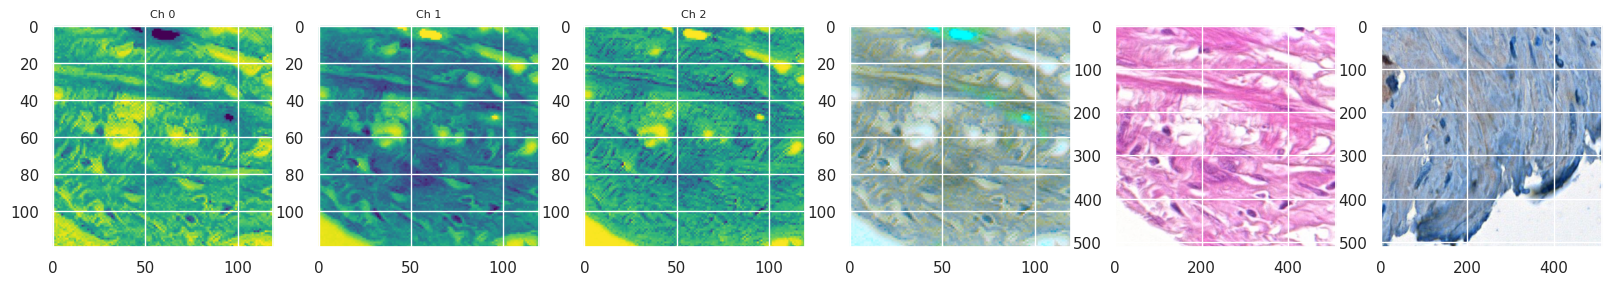

In [13]:
decoded = decoded.to(torch.uint8)
fig, axes = plt.subplots(1, 6, figsize=(20, 15))  # 1x5 grid
for i in range(3):
    ax = axes[i]
    ax.imshow(decoded[0, i].detach().cpu().numpy(), cmap='viridis')
    ax.set_title(f'Ch {i}', fontsize=8)
    # ax.axis('off')

axes[3].imshow(decoded[0].permute(1,2,0).detach().cpu().numpy(), cmap='viridis')
axes[4].imshow(src, cmap='viridis')
axes[5].imshow(dst, cmap='viridis')

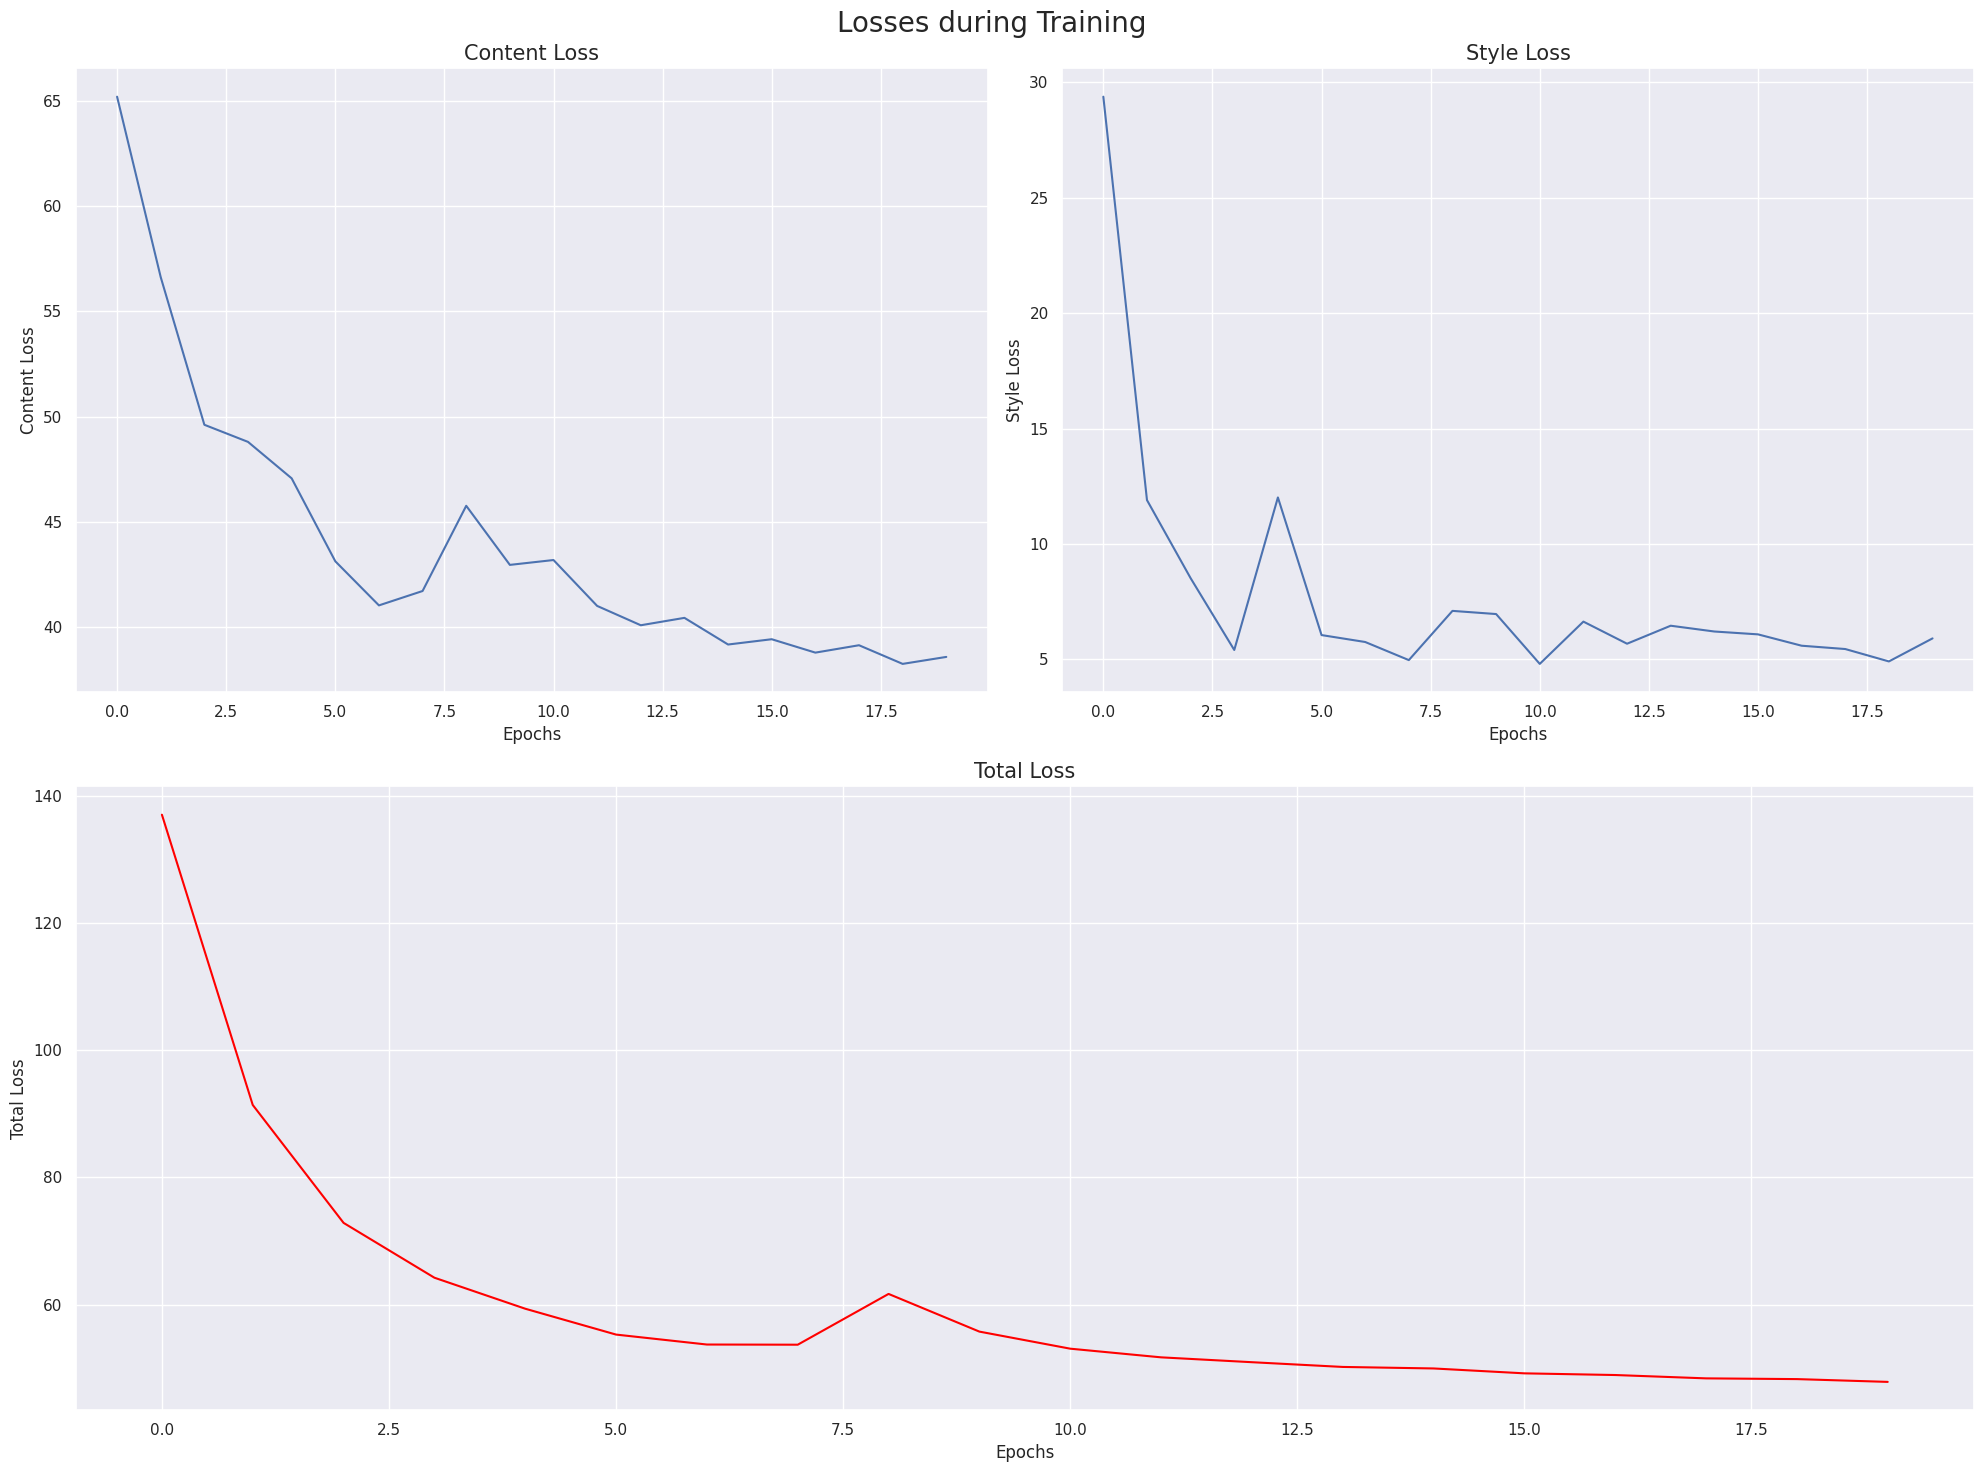

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(2, 2, height_ratios=[1, 1])

# Upper left: Content Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(content_losses, label='Content Loss')
ax1.set_title('Content Loss', fontsize=15)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Content Loss')

# Upper right: Style Loss
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(style_losses, label='Style Loss')
ax2.set_title('Style Loss', fontsize=15)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Style Loss')

# Bottom (spans both columns): Total Loss
ax3 = fig.add_subplot(gs[1, :])
ax3.plot(losses, label='Total Loss', color='red')
ax3.set_title('Total Loss', fontsize=15)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('Total Loss')

# Add title to fig
fig.suptitle('Losses during Training', fontsize=20)
plt.tight_layout()
plt.show()
